### SAM 2 Auto-Labeling Pipeline

This tool automatically generates YOLO segmentation labels (`.txt`) for image sequences using SAM 2.

**Input Requirements:**
* **Format:** Images must be `.jpg` or `.jpeg`.
* **Naming:** Filenames must be numeric and sequential (e.g., `000000.jpg`, `000001.jpg`).
* **Directory:**
    ```
    train_images
    └── {camera_serial_number}
        ├── 000000.jpg
        ├── 000001.jpg
        └── ...
    ```

**Output:**
* YOLO formatted `.txt` labels in a `labels/` subdirectory.
* An annotated video file for visual inspection of the tracking quality.


In [1]:
# 1. Install SAM 2, Supervision and the Widget
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git
!pip install -q jupyter_bbox_widget supervision


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
cd /content/drive/MyDrive/'Colab Notebooks/human-activity-understanding/HW2'

/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2


In [12]:
# 3. Download SAM 2.1 Medium (Hiera Base Plus) Checkpoint and Config
!mkdir -p checkpoints
!wget -q -O checkpoints/sam2.1_hiera_base_plus.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt
!wget -q -O checkpoints/sam2.1_hiera_base_plus.yaml https://raw.githubusercontent.com/facebookresearch/sam2/main/sam2/configs/sam2.1/sam2.1_hiera_b%2B.yaml

In [13]:
import cv2
import matplotlib.pyplot as plt
import os
# --- USER CONFIGURATION ---
# Path to your folder containing the your images (must be .jpg or .jpeg)
IMAGES_DIR = "/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467"

# --- LOAD FIRST IMAGE ---
image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])
first_image_path = os.path.join(IMAGES_DIR, image_files[0])

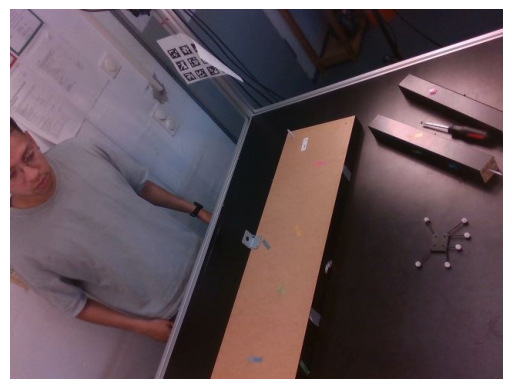

In [15]:


# Check if the image file exists

if os.path.exists(first_image_path):
    # Read the image
    image = cv2.imread(first_image_path)

    # Check if the image was loaded successfully
    if image is not None:
        # Convert BGR to RGB for matplotlib display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.imshow(image_rgb)

        plt.axis('off') # Hide axes ticks and labels

        plt.show()
    else:
        print(f"Error: Could not load image from '{IMAGE_PATH}'. Check file corruption or format.")
else:
    print(f"Error: Image '{IMAGE_PATH}' not found. Please ensure it's in the correct directory.")

In [16]:
# --- STEP 2: WIDGET & LOGIC ---

import numpy as np
from jupyter_bbox_widget import BBoxWidget
from IPython.display import display
import supervision as sv

import base64
from io import BytesIO
from PIL import Image

In [18]:

# --- CONFIGURATION ---
IMAGE_PATH = first_image_path
CLASSES = ["person","table", "leg1", "leg2","tool1"] # <--- 🏷 CHANGE YOUR CLASSES HERE

def encode_image(filepath):
    img = Image.open(filepath)

    # Determine the format and save to buffer
    img_format = img.format if img.format else "jpg" # Default to PNG if format is None
    buffer = BytesIO()
    img.save(buffer, format=img_format)

    # Encode to base64 and add data URI prefix
    img_b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f"data:image/{img_format.lower()};base64,{img_b64}"

# Initialize Widget
if os.path.exists(IMAGE_PATH):
    widget = BBoxWidget(
        image=encode_image(IMAGE_PATH),
        classes=CLASSES
    )
    print(f"👉 Draw boxes below for: {CLASSES}")
    display(widget)
else:
    print(f"❌ Error: Image '{IMAGE_PATH}' not found. Please upload it to Colab files.")

👉 Draw boxes below for: ['person', 'table', 'leg1', 'leg2', 'tool1']


Let's check the files in your current directory to make sure the image is there and the filename matches exactly.

In [19]:
import os
import shutil
import sam2

# 1. Locate the sam2 package's config directory
sam2_path = os.path.dirname(sam2.__file__)
sam2_configs_path = os.path.join(sam2_path, "configs")

# Ensure the target directory exists (it should if sam2 is installed)
os.makedirs(sam2_configs_path, exist_ok=True)

# 2. Source and destination paths for the config file
source_yaml_path = 'checkpoints/sam2.1_hiera_base_plus.yaml'
destination_yaml_path = os.path.join(sam2_configs_path, 'sam2.1_hiera_base_plus.yaml')

# 3. Copy the downloaded config file into the sam2's config directory
if os.path.exists(source_yaml_path):
    print(f"Copying '{source_yaml_path}' to '{destination_yaml_path}'")
    shutil.copy(source_yaml_path, destination_yaml_path)
    print("Copy successful.")
else:
    print(f"Error: Source YAML file '{source_yaml_path}' not found. Please ensure it's downloaded by running the download cell (2. Download SAM 2.1 Medium and Config) again.")

Copying 'checkpoints/sam2.1_hiera_base_plus.yaml' to '/usr/local/lib/python3.12/dist-packages/sam2/configs/sam2.1_hiera_base_plus.yaml'
Copy successful.


In [20]:
import torch
import numpy as np
from sam2.build_sam import build_sam2_video_predictor
import supervision as sv

# --- CONFIG ---
OUTPUT_DIR = os.path.join(IMAGES_DIR, "labels") # Labels saved in 'labels' subfolder
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Initialize SAM 2 Video Predictor
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "checkpoints/sam2.1_hiera_base_plus.pt"


cfg = 'configs/sam2.1_hiera_base_plus.yaml'

predictor = build_sam2_video_predictor(cfg, checkpoint, device=device)

# Initialize state on the folder of images
inference_state = predictor.init_state(video_path=IMAGES_DIR)

# 2. Register the boxes from Frame 0
print("🔄 Initializing tracking with your boxes...")

# Map to store which SAM object ID corresponds to which Class ID
# Format: {obj_id: class_id}
id_to_class_map = {}

for i, box_data in enumerate(widget.bboxes):
    obj_id = i + 1  # SAM 2 object IDs must be positive integers
    label = box_data['label']
    class_id = CLASSES.index(label)
    id_to_class_map[obj_id] = class_id

    # Convert Widget Box (y,x,h,w) to SAM Box (x1, y1, x2, y2)
    x_min, y_min = box_data['x'], box_data['y']
    x_max, y_max = x_min + box_data['width'], y_min + box_data['height']
    box_prompts = np.array([x_min, y_min, x_max, y_max], dtype=np.float32)

    # Add box to Frame 0
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=0,
        obj_id=obj_id,
        box=box_prompts
    )

# 3. Propagate to all 400 frames and Save
print(f"🚀 Tracking objects across {len(image_files)} frames...")

# Get image dimensions for normalization
img = cv2.imread(first_image_path)
H, W, _ = img.shape

# Propagate returns results for every frame in the video
for frame_idx, obj_ids, mask_logits in predictor.propagate_in_video(inference_state):

    yolo_lines = []
    current_file_name = image_files[frame_idx]

    # mask_logits contains masks for all objects in this frame
    # We iterate through them
    for i, obj_id in enumerate(obj_ids):
        # Get the class ID for this tracked object
        class_id = id_to_class_map.get(obj_id)
        if class_id is None: continue

        # Convert Logits to Binary Mask
        mask = (mask_logits[i] > 0.0).cpu().numpy().squeeze()

        # Convert Mask to Polygon (YOLO format)
        # sv.mask_to_xyxy handles the conversion logic efficiently
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(np.expand_dims(mask, 0)),
            mask=np.expand_dims(mask, 0)
        )

        for m in detections.mask:
            # Extract contours
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                if len(contour) > 2: # Filter noise
                    flattened = contour.flatten().tolist()
                    # Normalize 0-1
                    normalized = [val / W if k % 2 == 0 else val / H for k, val in enumerate(flattened)]
                    coords = " ".join([f"{v:.6f}" for v in normalized])
                    yolo_lines.append(f"{class_id} {coords}")

    # Save .txt file
    txt_name = os.path.splitext(current_file_name)[0] + ".txt"
    save_path = os.path.join(OUTPUT_DIR, txt_name)
    with open(save_path, "w") as f:
        f.write("\n".join(yolo_lines))

    if frame_idx % 50 == 0:
        print(f"   Processed frame {frame_idx}/{len(image_files)}")

print(f"✅ Done! Labels saved to: {OUTPUT_DIR}")

frame loading (JPEG): 100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


🔄 Initializing tracking with your boxes...
🚀 Tracking objects across 100 frames...


propagate in video:   0%|          | 0/100 [00:00<?, ?it/s]

   Processed frame 0/100


propagate in video:  51%|█████     | 51/100 [00:14<00:14,  3.29it/s]

   Processed frame 50/100


propagate in video: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]

✅ Done! Labels saved to: /content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/labels


### Sample of Saved YOLO Label Files

In [21]:

# Check if the output directory exists
if os.path.exists(OUTPUT_DIR):
    print(f"✅ Output directory '{OUTPUT_DIR}' exists.")

    # List all .txt files in the output directory
    label_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.txt')]

    print(f"Found {len(label_files)} label files in '{OUTPUT_DIR}'. Expected {len(image_files)}.")

    if len(label_files) == len(image_files):
        print("✅ Number of label files matches the number of image files.")

        # Optionally, print content of the first label file to verify format
        if label_files:
            first_label_file = sorted(label_files)[0] # Sort to get the first numeric file
            first_label_path = os.path.join(OUTPUT_DIR, first_label_file)
            print(f"\nContent of first label file '{first_label_file}':")
            with open(first_label_path, 'r') as f:
                print(f.read())
    else:
        print("❌ Mismatch: Number of label files does not match the number of image files.")
else:
    print(f"❌ Output directory '{OUTPUT_DIR}' does not exist.")


✅ Output directory '/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/labels' exists.
Found 100 label files in '/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/labels'. Expected 100.
✅ Number of label files matches the number of image files.

Content of first label file '000000.txt':
0 0.000000 0.293750 0.000000 0.697917 0.001563 0.700000 0.003125 0.700000 0.004687 0.702083 0.006250 0.702083 0.015625 0.714583 0.015625 0.716667 0.023438 0.727083 0.025000 0.727083 0.026562 0.729167 0.026562 0.731250 0.028125 0.733333 0.029687 0.733333 0.031250 0.735417 0.031250 0.737500 0.037500 0.745833 0.037500 0.747917 0.042188 0.754167 0.043750 0.754167 0.053125 0.766667 0.054688 0.766667 0.057813 0.770833 0.059375 0.770833 0.064062 0.777083 0.065625 0.777083 0.071875 0.785417 0.073438 0.785417 0.076563 0.789583 0.079687 0.789583 0.082812 0.793750 0.084375 0.793750 0.087500 0.797917 0.089063 0.797917 0.0

📸 Visualizing: 000033.jpg
📄 Reading label: 000033.txt


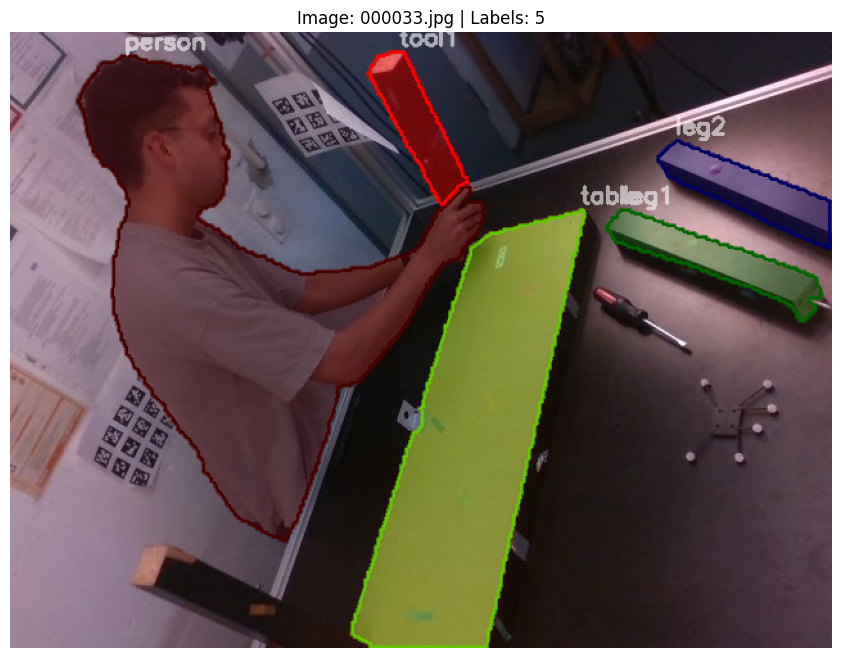

In [48]:
import random
import glob

# --- CONFIG ---
# Ensure these match your previous steps
CLASSES = ["person","table", "leg1", "leg2", "tool1"]
# IMAGES_DIR should be the folder with your numbered JPGs
# OUTPUT_DIR should be the folder with your .txt labels

# Define colors for each class (R, G, B)
COLORS = {
    0: (70, 0, 0),    # person: Red
    1: (100, 200,0),    # table:
    2: (0, 100, 0),    # leg1: Green
    3: (0, 0, 100),     # leg2: Blue
    4: (255, 0, 0)   # tool
}

def visualize_random_sample():
    # 1. Get List of Images
    jpg_files = glob.glob(os.path.join(IMAGES_DIR, "*.jpg"))

    if not jpg_files:
        print("❌ No images found in IMAGES_DIR.")
        return

    # 2. Pick a random image
    img_path = random.choice(jpg_files)
    file_name = os.path.basename(img_path)
    txt_name = os.path.splitext(file_name)[0] + ".txt"
    label_path = os.path.join(OUTPUT_DIR, txt_name)

    print(f"📸 Visualizing: {file_name}")
    print(f"📄 Reading label: {txt_name}")

    # 3. Load Image
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Error loading image.")
        return

    # Convert BGR (OpenCV) to RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # Create a copy for the semi-transparent overlay
    overlay = img_rgb.copy()

    # 4. Read Labels
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 3: continue

            class_id = int(parts[0])

            # Parse normalized coordinates
            # Format: class_id x1 y1 x2 y2 ...
            coords = [float(x) for x in parts[1:]]

            # Reshape into (N, 2) and Denormalize
            points = np.array(coords).reshape(-1, 2)
            points[:, 0] *= w # Scale x
            points[:, 1] *= h # Scale y
            points = points.astype(np.int32)

            # Get Color
            color = COLORS.get(class_id, (255, 255, 255))
            class_name = CLASSES[class_id] if class_id < len(CLASSES) else str(class_id)

            # Draw Filled Polygon on Overlay
            cv2.fillPoly(overlay, [points], color)

            # Draw Outline on Main Image
            cv2.polylines(img_rgb, [points], isClosed=True, color=color, thickness=2)

            # Draw Text Label
            # Find top-left point of the polygon for text placement
            text_x, text_y = points[0]
            cv2.putText(img_rgb, class_name, (text_x, text_y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # 5. Blend Overlay and Image (Transparency)
        alpha = 0.4  # Transparency factor
        img_final = cv2.addWeighted(overlay, alpha, img_rgb, 1 - alpha, 0)

        # 6. Show Plot
        plt.figure(figsize=(12, 8))
        plt.imshow(img_final)
        plt.axis('off')
        plt.title(f"Image: {file_name} | Labels: {len(lines)}")
        plt.show()

    else:
        print("⚠️ No label file found for this image (it might be an empty frame).")
        plt.imshow(img_rgb)
        plt.show()

# Run the function
visualize_random_sample()

# Task
Generate a video using the annotated frames from the directory `/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467` with corresponding labels from `/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/labels`. The video should apply the masks and labels to each frame, save each annotated frame to a temporary directory, compile these frames into a video file, and then clean up the temporary files.

## Generate annotated frames

### Subtask:
Modify the visualization function to iterate through all images, apply the masks and labels, and save each annotated frame to a temporary directory.


**Reasoning**:
The first step is to define the temporary directory where the annotated frames will be saved and ensure that this directory exists. This follows instruction 1.



In [49]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a temporary directory to store annotated frames
TEMP_ANNOTATED_FRAMES_DIR = os.path.join(IMAGES_DIR, "annotated_frames")
os.makedirs(TEMP_ANNOTATED_FRAMES_DIR, exist_ok=True)
print(f"Created temporary directory for annotated frames: {TEMP_ANNOTATED_FRAMES_DIR}")

Created temporary directory for annotated frames: /content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/annotated_frames


**Reasoning**:
Now that the temporary directory is set up, I will define the `annotate_and_save_frame` function which encapsulates the logic for loading an image, reading its YOLO label file, denormalizing coordinates, drawing polygons and text, blending an overlay, and saving the annotated frame to the temporary directory, following instructions 2-7.



In [50]:
def annotate_and_save_frame(image_path, label_path, frame_idx, h, w):
    # Load Image
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error loading image: {image_path}")
        return

    # Convert BGR (OpenCV) to RGB (Matplotlib for consistency, though saving will be BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = img_rgb.copy()

    # Read Labels
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 3: continue

            class_id = int(parts[0])
            coords = [float(x) for x in parts[1:]]

            # Reshape into (N, 2) and Denormalize
            points = np.array(coords).reshape(-1, 2)
            points[:, 0] *= w # Scale x
            points[:, 1] *= h # Scale y
            points = points.astype(np.int32)

            # Get Color
            color_rgb = COLORS.get(class_id, (255, 255, 255)) # Default to white
            # Convert RGB color to BGR for OpenCV drawing functions
            color_bgr = (color_rgb[2], color_rgb[1], color_rgb[0])

            class_name = CLASSES[class_id] if class_id < len(CLASSES) else str(class_id)

            # Draw Filled Polygon on Overlay (using BGR color)
            cv2.fillPoly(overlay, [points], color_bgr)

            # Draw Outline on Main Image (using BGR color)
            cv2.polylines(img, [points], isClosed=True, color=color_bgr, thickness=2)

            # Draw Text Label
            # Find top-left point of the polygon for text placement
            if len(points) > 0:
                text_x, text_y = points[0][0], points[0][1]
                cv2.putText(img, class_name, (text_x, text_y - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_bgr, 2) # Use BGR color for text

    # Blend Overlay and Image (Transparency) - use original BGR image for blending with BGR overlay
    alpha = 0.4  # Transparency factor
    img_final = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    # Save the annotated image
    base_filename = os.path.basename(image_path)
    output_filename = f"annotated_{base_filename}"
    save_path = os.path.join(TEMP_ANNOTATED_FRAMES_DIR, output_filename)
    cv2.imwrite(save_path, img_final)


# Get image dimensions for normalization (assuming all images have the same dimensions)
# This was already done, but to ensure it's available in this scope if the kernel resets between cells
if 'H' not in globals() or 'W' not in globals():
    first_image_path = os.path.join(IMAGES_DIR, image_files[0])
    first_img = cv2.imread(first_image_path)
    if first_img is not None:
        H, W, _ = first_img.shape
    else:
        raise ValueError(f"Could not load first image to determine dimensions: {first_image_path}")


print(f"Found {len(image_files)} images to annotate.")
# Iterate through all image files and apply annotation
for i, file_name in enumerate(image_files):
    image_path = os.path.join(IMAGES_DIR, file_name)
    label_filename = os.path.splitext(file_name)[0] + ".txt"
    label_path = os.path.join(OUTPUT_DIR, label_filename)

    annotate_and_save_frame(image_path, label_path, i, H, W)

    if i % 10 == 0:
        print(f"Processed and saved annotated frame {i+1}/{len(image_files)}")

print(f"✅ All frames annotated and saved to {TEMP_ANNOTATED_FRAMES_DIR}")

Found 100 images to annotate.
Processed and saved annotated frame 1/100
Processed and saved annotated frame 11/100
Processed and saved annotated frame 21/100
Processed and saved annotated frame 31/100
Processed and saved annotated frame 41/100
Processed and saved annotated frame 51/100
Processed and saved annotated frame 61/100
Processed and saved annotated frame 71/100
Processed and saved annotated frame 81/100
Processed and saved annotated frame 91/100
✅ All frames annotated and saved to /content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/annotated_frames


## Create video from frames

### Subtask:
Use OpenCV's `VideoWriter` to compile the sequence of annotated frames into a video file.


**Reasoning**:
Now that all frames are annotated and saved to a temporary directory, the next step is to compile these annotated frames into a video file using OpenCV's `VideoWriter`.



In [51]:
import glob

# --- VIDEO CONFIGURATION ---
VIDEO_OUTPUT_PATH = os.path.join(IMAGES_DIR, "annotated_video.mp4")
FPS = 15  # Frames per second
# H and W are already defined from previous steps (image dimensions)

# Initialize VideoWriter
# Codec for .mp4: 'mp4v'
# Other common codecs: 'MJPG' (for .avi), 'XVID'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(VIDEO_OUTPUT_PATH, fourcc, FPS, (W, H))

# Get a sorted list of all annotated image files
annotated_files = sorted(glob.glob(os.path.join(TEMP_ANNOTATED_FRAMES_DIR, "annotated_*.jpg")))

if not annotated_files:
    print(f"❌ No annotated frames found in {TEMP_ANNOTATED_FRAMES_DIR}. Cannot create video.")
else:
    print(f"🎬 Compiling {len(annotated_files)} annotated frames into video: {VIDEO_OUTPUT_PATH}")
    # Loop through the sorted list of annotated image files and write to video
    for i, frame_path in enumerate(annotated_files):
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"⚠️ Warning: Could not read frame {frame_path}. Skipping.")
            continue
        video_writer.write(frame)

        if i % 20 == 0:
            print(f"   Added frame {i+1}/{len(annotated_files)} to video.")

    # Release the VideoWriter object
    video_writer.release()

    print(f"✅ Video successfully created at: {VIDEO_OUTPUT_PATH}")

🎬 Compiling 100 annotated frames into video: /content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/annotated_video.mp4
   Added frame 1/100 to video.
   Added frame 21/100 to video.
   Added frame 41/100 to video.
   Added frame 61/100 to video.
   Added frame 81/100 to video.
✅ Video successfully created at: /content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/annotated_video.mp4


In [53]:
import shutil

# Clean up temporary annotated frames directory
if os.path.exists(TEMP_ANNOTATED_FRAMES_DIR):
    shutil.rmtree(TEMP_ANNOTATED_FRAMES_DIR)
    print(f"✅ Cleaned up temporary directory: {TEMP_ANNOTATED_FRAMES_DIR}")

### Video Display using HTML

<video controls src="/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/HW2/train_images/141722079467/annotated_video.mp4" width="640" height="480"></video>

If you still can't see the video, please ensure your browser supports HTML5 video and try downloading it from the path provided previously.